In any regression or classification problem where observations have a time element, old patterns can become stale. For this reason, I'm often asking myself -- how do I upweight my most recent observations? In this post I explain how to do this.

All the code in this tutorial is available as a [jupyter notebook](https://github.com/jackcbaker/blog-notebooks/blob/main/regression-forgetting.ipynb) on my [github](https://github.com/jackcbaker/).

## Step 1: Fetch the data

For this post I'll be using price data from the [S&P500 available via Kaggle's](https://www.kaggle.com/camnugent/sandp500) great dataset library. This dataset is released under the [creative commons 0 license](https://creativecommons.org/publicdomain/zero/1.0/).

A common problem in financial investments is to ensure you have a _balanced portfolio_. If your portfolio is unbalanced it means that if one stock starts to perform poorly, all of them do. This means any portfolio risks can have a massive effect on value. 

The ideal scenario is that if any stock started to decrease, this would be _balanced_ by an increase in another one: a balanced portfolio.

So we can just calculate the correlation coefficient between all the stocks in our portfolio and be done right? Not quite. These relationships tend to change through time, which is something we need to account for.

In this post we'll use a regression model where recent observations are given more weight to model the relationship between two stocks. This ensures when deciding how balanced the stocks are we are taking into account that the relationship is likely to change over time.

The tutorial can be applied to any regression or classification problem where you suspect observations are likely to 'get stale' or where relationships may change over time.

For this tutorial we're going to compare the closing share price of American Express (AXP) to Apple's (AAPL). First let's load the dataset after downloading it from Kaggle...

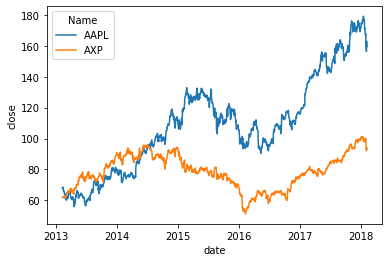

In [3]:
import pandas as pd
# for plotting
import seaborn as sns
# We'll need this later...
from sklearn.linear_model import LinearRegression

# Load in the full dataset rather than individual stocks
snp_df = pd.read_csv("data/all_stocks_5yr.csv")
# Subset to just Nike and Apple stocks
snp_df = snp_df.loc[snp_df['Name'].isin(['AXP', 'AAPL'])]
# Just take the columns we need
snp_df = snp_df[['date', 'close', 'Name']]
# Set dates to be datetime objects
snp_df['date'] = pd.to_datetime(snp_df['date'])
# Plot the data
sns.lineplot(data=snp_df, x='date', y='close', hue='Name')
# Reshape the data to wide format
snp_df = snp_df.pivot(index='date', columns='Name', values='close').reset_index()

We can see from the plot above that initially there is quite a strong relationship between Apple and American Express prices. This is weakened when the American Express price starts to fall. But after this the relationship appears to get stronger again. This suggests a model that accounts for the fact that relationships change through time might be better. It also suggests that most of the time these stocks are imbalanced: they tend to move together.

## Step 2: Adding weights

Now we need to decide how to weight the observations. There are lots of options here, which is a bit confusing.

I tend to use the same weights as used in [exponential smoothing models](https://otexts.com/fpp3/ses.html). Why? Exponential smoothing is a popular, simple forecasting method that has been around for over 60 years! It's tried and tested, and has not gone away.

Let's set $T$ to be the time of the most recent observation, $t$ to be the time of the observation we're interested in, and $\gamma$ to be a hyperparameter we pick that's between 0 and 1. Then I set my weights $w$ to be

\begin{equation}
w = \gamma^{[T-t]}.
\end{equation}

What does this mean? Suppose we set $\gamma = 0.95$. Then if my observation is made at the most recent time point, its weight will be 1. If it's made at the second most recent time point, its weight will be 0.95. If it's made at the 10th most recent time point, its weight will be $\gamma^10 = 0.95^10 \approx 0.6$. Essentially our weight smoothly decreases to nothing as the observation gets older and older.

An unfortunate side effect to this is we've added a hyperparameter to tune. I often just quickly do this by eye looking at the data, but you can also tune this in the normal way using cross-validation or AIC/BIC. For this tutorial, I'll just set it to 0.8.

Let's add weights to our data now:

In [49]:
# Set hyperparam
gamma = 0.8
# Check both stocks go up to the same date
most_recent_date = snp_df['date'].max()
days_before_recent_date = (most_recent_date - snp_df['date']).dt.days
snp_df['weight'] = gamma ** days_before_recent_date.values
snp_df

Name,date,AAPL,AXP,weight
0,2013-02-08,67.8542,61.80,1.377927e-177
1,2013-02-11,68.5614,61.98,2.691264e-177
2,2013-02-12,66.8428,62.20,3.364080e-177
3,2013-02-13,66.7156,62.10,4.205100e-177
4,2013-02-14,66.6556,62.34,5.256375e-177
...,...,...,...,...
1254,2018-02-01,167.7800,100.00,2.621440e-01
1255,2018-02-02,160.5000,96.68,3.276800e-01
1256,2018-02-05,156.4900,92.01,6.400000e-01
1257,2018-02-06,163.0300,94.18,8.000000e-01


## Step 3: Fit your model

You might think that fitting our model will become a challenge now we've added weights. It's actually dead easy.

Most regression and classification algorithms allow you to provide a dataset weight: for tree based methods (sklearn random forest, xgboost, lightgbm), you just set the `sample_weight` in the `fit` function; for linear regression R's `lm` function has a `weights` argument, sklearn's `LinearRegression` has a `sample_weight` argument in the `fit` function.

If your algorithm does not allow you to set a weight, you can borrow from the class imbalance techniques and [oversample/undersample](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) your observations based on your weights.

Let's fit our model using sklearn's linear regression:

In [55]:
weighted_model = LinearRegression()
weighted_results = weighted_model.fit(
    X=snp_df[['AAPL']],
    y=snp_df['AXP'], 
    sample_weight=snp_df['weight']
)
# Return the R^2 score for our model
r2_weighted = weighted_results.score(
    X=snp_df[['AAPL']],
    y=snp_df['AXP'], 
    sample_weight=snp_df['weight']
)
print(f"R^2 score for the weighted model is {r2_weighted}")

print(f"Linear coefficient of relationship of Apple to American Express is {weighted_model.coef_[0]}")

R^2 score for the weighted model is 0.740848229773393
Linear coefficient of relationship of Apple to American Express is 0.4810444526330664


Let's compare this to an unweighted model:

In [56]:
unweighted_model = LinearRegression()
unweighted_results = unweighted_model.fit(
    X=snp_df[['AAPL']],
    y=snp_df['AXP']
)
# Return the R^2 score for our model
r2_unweighted = unweighted_results.score(
    X=snp_df[['AAPL']],
    y=snp_df['AXP']
)
print(f"R^2 score for the unweighted model is {r2_unweighted}")

print(f"Linear coefficient of relationship of Apple to American Express is {unweighted_model.coef_[0]}")

R^2 score for the unweighted model is 0.1161401914047755
Linear coefficient of relationship of Apple to American Express is 0.12149913600503894


In this case we've improved our in-sample fit significantly by using the weighted model. The coefficient is larger for the weighted model. This suggests that while previously, these stocks have not been that related, recently the stocks have become less balanced. This makes sense from what we saw when we plotted the two timeseries. This would be an increasing risk for our portfolio.